In [29]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
__file__ = './'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

# os.path.dirname(__file__)获取当前文件的绝对路径
# os.path.join(xx,'..')在后面追加..，相当于进入上一级目录
# os.path.abspath(xx)获取绝对路径
# sys.path.append()将其加入系统路径当中

import MSA
import LINK

In [32]:
# read data
my_link = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='link_info')
my_link['I'] = 0
my_node = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='node_info')
my_link['name'] = my_link['from'].astype('str') +'-'+ my_link['to'].astype('str')
my_demand = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='demand_info')
print(my_demand)

# set parameter
origin_zone = ['r1']
destination_zone = ['s1']
theta_1 = 1 # path 
theta_2 = 0.5 # mode
miu_in = 25
miu_out = 30
lamda_0_hailing = 2 #2 RMB/minute
lamda_0_PR = 20 # RMB
lamda_0_transit = 5
N_hailing = 500
lamda_0_auto = LINK.compute_lamda_0_auto(fuel_consumption=8.5)

df = []
first_mile = np.arange(0.5, 10.2, 0.5) 
for distance in first_mile:
    my_link.l_a[my_link.attribute == 'board_transit'] = distance
    result = MSA.assignment(my_link= my_link, my_node= my_node, my_demand= my_demand,
                        origin_zone= origin_zone, destination_zone= destination_zone,
                        miu_in= miu_in, miu_out= miu_out,
                        lamda_0_auto= lamda_0_auto,
                        lamda_0_hailing= lamda_0_hailing,
                        lamda_0_transit= lamda_0_transit,
                        lamda_0_PR= lamda_0_PR,
                        theta_1= theta_1, theta_2= theta_2,
                        N_hailing= N_hailing, A=2, maximum_iter=300)
    df.append(result)

# system cost
total_cost = []
for item in df:
    flow_set = item[2].tail(item[6])
    cost = sum(abs(flow_set['path_cost']) * flow_set['path_flow'])
    total_cost.append(cost)

# OD cost
def od_cost(path, od):
    
    cost = sum(abs(path[path['OD_pair'] == od]['path_cost']) * path[path['OD_pair'] == od]['path_flow'])
    return cost

od_1_cost = []
od_2_cost = []
od_3_cost = []
od_4_cost = []
for i in range(len(df)):
    flow_set = df[i][2].tail(df[i][6])
    od_1_cost.append(od_cost(flow_set, 'r1-s1'))
    od_2_cost.append(od_cost(flow_set, 'r1-s2'))
    od_3_cost.append(od_cost(flow_set, 'r2-s1'))
    od_4_cost.append(od_cost(flow_set, 'r2-s2'))

# mode share
PR_logit = [df[i][4].tail(df[i][7]).iloc[0]['mode_logit'] for i in range(len(df))]
RT_logit = [df[i][4].tail(df[i][7]).iloc[1]['mode_logit'] for i in range(len(df))]
auto_logit = [df[i][4].tail(df[i][7]).iloc[2]['mode_logit'] for i in range(len(df))]
bus_logit = [df[i][4].tail(df[i][7]).iloc[3]['mode_logit'] for i in range(len(df))]

# path_flow
path_1_flow = [df[i][2].tail(df[i][6]).iloc[0]['path_flow'] for i in range(len(df))]
path_2_flow = [df[i][2].tail(df[i][6]).iloc[1]['path_flow'] for i in range(len(df))]
path_3_flow = [df[i][2].tail(df[i][6]).iloc[2]['path_flow'] for i in range(len(df))]
path_4_flow = [df[i][2].tail(df[i][6]).iloc[3]['path_flow'] for i in range(len(df))]

# path_duration
path_1_duration = [df[i][2].tail(df[i][6]).iloc[0]['path_duration'] for i in range(len(df))]
path_2_duration = [df[i][2].tail(df[i][6]).iloc[1]['path_duration'] for i in range(len(df))]
path_3_duration = [df[i][2].tail(df[i][6]).iloc[2]['path_duration'] for i in range(len(df))]
path_4_duration = [df[i][2].tail(df[i][6]).iloc[3]['path_duration'] for i in range(len(df))]

# path_cost
path_1_cost = [abs(df[i][2].tail(df[i][6]).iloc[0]['path_cost']) for i in range(len(df))]
path_2_cost = [abs(df[i][2].tail(df[i][6]).iloc[1]['path_cost']) for i in range(len(df))]
path_3_cost = [abs(df[i][2].tail(df[i][6]).iloc[2]['path_cost']) for i in range(len(df))]
path_4_cost = [abs(df[i][2].tail(df[i][6]).iloc[3]['path_cost']) for i in range(len(df))]

# ride-hailing vehicle number
n_idle = [df[i][5].tail(1).iloc[0]['n_idle'] for i in range(len(df))]
waiting_hailing = [df[i][5].tail(1).iloc[0]['wait_time'] for i in range(len(df))]

# convert to dataframe
dfx = pd.DataFrame({
        'distance': first_mile,
        'n_idle': n_idle,
        'waiting time': waiting_hailing,
        'total_cost': total_cost,
        'auto_logit': auto_logit,
        'bus_logit': bus_logit,
        'PR_logit': PR_logit,
        'RT_logit': RT_logit,
        'path_1_flow': path_1_flow,
        'path_2_flow': path_2_flow,
        'path_3_flow': path_3_flow,
        'path_4_flow': path_4_flow,
        'path_1_cost': path_1_cost,
        'path_2_cost': path_2_cost,
        'path_3_cost': path_3_cost,
        'path_4_cost': path_4_cost,
        'path_1_duration': path_1_duration,
        'path_2_duration': path_2_duration,
        'path_3_duration': path_3_duration,
        'path_4_duration': path_4_duration,})

  OD_pair  demand
0   r1-s1    1000
0.6517
['path-1', 'path-2', 'path-3', 'path-4']
['auto', 'P&R', 'transit', 'R&T']
Iteration = 1, gap = 1.3403711843802788,
the number of idle_hailing:500.0
Iteration = 2, gap = 9.584691712011924,
the number of idle_hailing:403.32091568086787
Iteration = 3, gap = 4.449578808195662,
the number of idle_hailing:400.8659870208936
Iteration = 4, gap = 2.872767559463667,
the number of idle_hailing:400.73970986164613
Iteration = 5, gap = 2.111568721250967,
the number of idle_hailing:400.70603009434217
Iteration = 6, gap = 1.664818080626839,
the number of idle_hailing:400.6869556702753
Iteration = 7, gap = 1.3717014403438181,
the number of idle_hailing:400.67455008542606
Iteration = 8, gap = 1.164920291326989,
the number of idle_hailing:400.6659571344609
Iteration = 9, gap = 1.0114003321879828,
the number of idle_hailing:400.65973321218866
Iteration = 10, gap = 0.8930122011388348,
the number of idle_hailing:400.65506812612233
Iteration = 11, gap = 0.798996970

In [33]:
dfx

,distance,n_idle,waiting time,total_cost,auto_logit,bus_logit,PR_logit,RT_logit,path_1_flow,path_2_flow,path_3_flow,path_4_flow,path_1_cost,path_2_cost,path_3_cost,path_4_cost,path_1_duration,path_2_duration,path_3_duration,path_4_duration
0,0.5,400.633720,5.709980,99339.478390,0.247811,0.262504,0.238232,0.251453,247.812848,238.263139,262.469695,251.454318,103.935716,138.209097,65.594047,93.202973,33.873304,123.528380,139.211426,119.602281
1,1.0,400.507170,5.710839,100132.414417,0.248066,0.261655,0.238505,0.251774,248.063346,238.499582,261.671624,251.765449,104.106943,138.317671,68.245967,93.184185,33.929108,123.524933,144.504607,119.557020
2,1.5,400.378205,5.711715,100927.001621,0.248314,0.260824,0.238771,0.252091,248.311355,238.765780,260.840386,252.082479,104.285409,138.434055,70.897830,93.165610,33.987271,123.524586,149.797649,119.512264
3,2.0,400.251752,5.712574,101715.737527,0.248557,0.260009,0.239032,0.252402,248.554367,239.026656,260.025666,252.393311,104.460831,138.548535,73.550289,93.147422,34.044442,123.524419,155.092121,119.468441
4,2.5,400.127710,5.713417,102498.792900,0.248795,0.259210,0.239288,0.252707,248.792537,239.282407,259.226869,252.698188,104.633299,138.661165,76.203322,93.129608,34.100650,123.524424,160.387972,119.425519
5,3.0,400.006053,5.714245,103276.294559,0.249029,0.258427,0.239538,0.253006,249.025931,239.533103,258.443786,252.997180,104.802830,138.771954,78.856919,93.112164,34.155902,123.524592,165.685177,119.383486
6,3.5,399.886750,5.715056,104048.368066,0.249258,0.257659,0.239784,0.253299,249.254619,239.778810,257.676211,253.290360,104.969443,138.880909,81.511070,93.095082,34.210202,123.524913,170.983710,119.342328
7,4.0,399.769686,5.715853,104815.172614,0.249482,0.256907,0.240025,0.253587,249.478740,240.019725,256.923519,253.578016,105.133224,138.988088,84.165755,93.078352,34.263579,123.525383,176.283525,119.302018
8,4.5,399.655002,5.716634,105576.761169,0.249701,0.256170,0.240261,0.253868,249.698217,240.255665,256.186317,253.859801,105.294064,139.093403,86.820981,93.061980,34.315998,123.525983,181.584641,119.262567
9,5.0,399.542585,5.717400,106333.290060,0.249916,0.255447,0.240492,0.254145,249.913191,240.486823,255.463991,254.135996,105.452048,139.196914,89.476731,93.045953,34.367486,123.526710,186.887012,119.223950


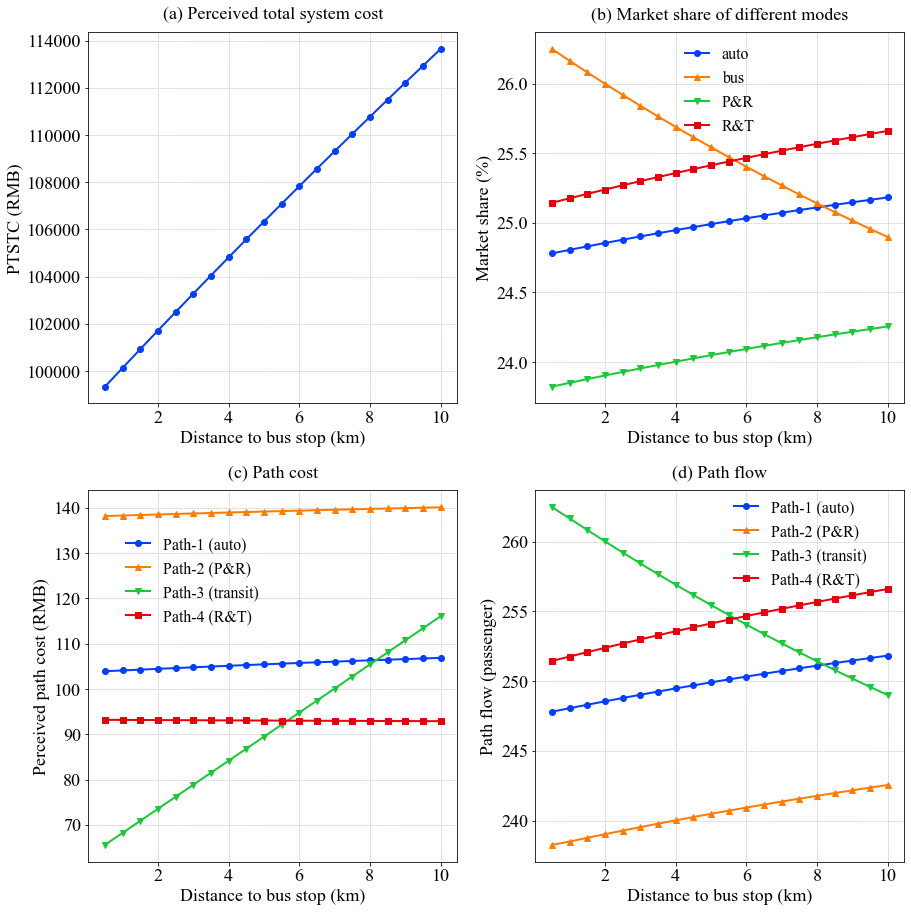

In [34]:
import seaborn as sns
sns.set_palette("bright", 10)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

fig = plt.figure(figsize=(13,13))
markers = ['o','^','v','s','h','D','p','<','>']

ax = plt.subplot(2,2,1)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['distance'], dfx['total_cost'], '-', lw=2, marker='o')
ax.set_xlabel('Distance to bus stop (km)')
ax.set_ylabel('PTSTC (RMB)')
ax.set_title('(a) Perceived total system cost', fontsize=18, loc='center', y=1.02)

ax = plt.subplot(2,2,2)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['distance'], dfx['auto_logit']*100, '-', lw=2, marker=markers[0], label='auto')
ax.plot(dfx['distance'], dfx['bus_logit']*100, '-', lw=2, marker=markers[1], label='bus')
ax.plot(dfx['distance'], dfx['PR_logit']*100, '-', lw=2, marker=markers[2], label='P&R')
ax.plot(dfx['distance'], dfx['RT_logit']*100, '-', lw=2, marker=markers[3], label='R&T')
ax.set_xlabel('Distance to bus stop (km)')
ax.set_ylabel('Market share (%)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5) #, bbox_to_anchor=(0.7,0.7)
ax.set_title('(b) Market share of different modes', fontsize=18, loc='center', y=1.02,)

ax = plt.subplot(2,2,3)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['distance'], dfx['path_1_cost'], '-', lw=2, marker='o',label='Path-1 (auto)')
ax.plot(dfx['distance'], dfx['path_2_cost'], '-', lw=2, marker='^',label='Path-2 (P&R)')
ax.plot(dfx['distance'], dfx['path_3_cost'], '-', lw=2, marker='v',label='Path-3 (transit)')
ax.plot(dfx['distance'], dfx['path_4_cost'], '-', lw=2, marker='s',label='Path-4 (R&T)')
ax.set_xlabel('Distance to bus stop (km)')
ax.set_ylabel('Perceived path cost (RMB)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5,bbox_to_anchor = (0.5,0.6)) #,bbox_to_anchor = (0.6,0.4)
ax.set_title('(c) Path cost', fontsize=18, loc='center', y=1.02)

ax = plt.subplot(2,2,4)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['distance'], dfx['path_1_flow'], '-', lw=2, marker='o',label='Path-1 (auto)')
ax.plot(dfx['distance'], dfx['path_2_flow'], '-', lw=2, marker='^',label='Path-2 (P&R)')
ax.plot(dfx['distance'], dfx['path_3_flow'], '-', lw=2, marker='v',label='Path-3 (transit)')
ax.plot(dfx['distance'], dfx['path_4_flow'], '-', lw=2, marker='s',label='Path-4 (R&T)')
ax.set_xlabel('Distance to bus stop (km)')
ax.set_ylabel('Path flow (passenger)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5, bbox_to_anchor = (0.5,0.7),)  
ax.set_title('(d) Path flow', fontsize=18, loc='center', y=1.02)

plt.tight_layout()
plt.show()

In [35]:
my_link

,link_id,from,to,type,attribute,c_a,l_a,f_bus,t_0,travel,fare_rate,walk,wait,congestion,penalty,flow,I,name
0,1,N1,N2,physical,auto,300,10.0,0,10.0,21.062531,55.851512,0.000000,0.000000,0.000000,0,494.381329,32,N1-N2
1,2,N2,N3,physical,auto,200,10.0,0,10.0,13.770537,36.515333,0.000000,0.000000,0.000000,0,251.830300,32,N2-N3
2,3,N2,N5,pseudo,P&R,300,0.8,10,5.0,5.320471,20.000000,5.000000,6.000000,0.000000,12,242.551029,32,N2-N5
3,4,N4,N5,physical,transit,200,10.0,4,30.0,30.000000,0.000000,0.000000,0.000000,1.675373,0,249.010714,32,N4-N5
4,5,N5,N6,physical,transit,250,10.0,4,30.0,30.000000,0.000000,0.000000,0.000000,45.442046,0,748.169700,32,N5-N6
5,6,N8,N5,pseudo,R&T,0,0.0,10,0.0,0.000000,0.000000,3.000000,6.000000,0.000000,12,256.607957,32,N8-N5
6,7,N7,N8,physical,ride-hailing,200,10.0,0,15.0,15.000000,30.000000,0.000000,0.000000,0.000000,0,256.607957,32,N7-N8
7,8,r1,N1,pseudo,board_auto,0,0.0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,494.381329,32,r1-N1
8,9,N3,s1,pseudo,alight_auto,0,0.0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,251.830300,32,N3-s1
9,10,r1,N4,pseudo,board_transit,0,10.0,4,0.0,0.000000,0.000000,107.142857,15.000000,0.000000,0,249.010714,32,r1-N4
